# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                 
Sample_027  Q12797;Q12797-10                  12.535
Sample_209  Q9BQT9;Q9BQT9-2                   19.537
Sample_026  O60245;O60245-2                   15.434
Sample_055  G3V533;Q6ZMZ3;Q6ZMZ3-2;Q6ZMZ3-3   17.297
Sample_083  O43405                            18.628
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups
Sample_062  J9JIG6;Q96EG1    13.578
Sample_012  Q92820           16.501
Sample_189  Q8IUC8           15.010
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 14.105
            A0A075B6Q5                 12.743
            A0A075B6R2                 12.422
            A0A075B6S5                 13.409
            A0A087WSY4                 11.970
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.610
            Q9UI40;Q9UI40-2            12.244
            Q9UIW2                     12.841
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.255
            Q9UP79                     11.590
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,11.537,15.050,16.842,19.863,13.481,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,14.921,19.067,...,15.528,15.576,12.048,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,13.842,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,12.314,17.705,17.039,14.379,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,14.745,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,11.840,15.345,17.084,18.708,14.249,19.433,10.692,5.955
Sample_207,15.739,16.877,15.469,16.898,13.887,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.096,12.728,13.566,13.162,11.806,13.089,12.316,12.934,13.095,11.869
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,14.425,19.067,16.127,...,12.328,11.572,12.424,13.374,12.050,13.234,13.678,13.456,12.619,12.914
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.989,12.488,12.456,12.191,13.132,13.090,12.582,13.717,12.256,12.456
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.519,12.949,12.984,12.647,12.000,13.037,12.352,11.915,13.489,12.117
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,11.243,11.658,13.443,11.202,13.495,13.090,12.489,13.217,12.131,12.336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.076,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 317.77it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.54it/s]

100%|██████████| 2/2 [00:00<00:00,  6.52it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.59it/s]

100%|██████████| 3/3 [00:00<00:00,  4.35it/s]

100%|██████████| 3/3 [00:00<00:00,  4.52it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.71it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.42it/s]

100%|██████████| 4/4 [00:01<00:00,  3.04it/s]

100%|██████████| 4/4 [00:01<00:00,  3.27it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.55it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.67it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.36it/s]

100%|██████████| 5/5 [00:01<00:00,  3.39it/s]

100%|██████████| 5/5 [00:01<00:00,  3.58it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.87it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.76it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  5.04it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.90it/s]

100%|██████████| 6/6 [00:01<00:00,  3.34it/s]

100%|██████████| 6/6 [00:01<00:00,  4.04it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.10it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.11it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.80it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.31it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.28it/s]

100%|██████████| 7/7 [00:01<00:00,  3.79it/s]

100%|██████████| 7/7 [00:01<00:00,  4.26it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.71it/s]

 38%|███▊      | 3/8 [00:00<00:00,  6.20it/s]

 50%|█████     | 4/8 [00:00<00:00,  5.21it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  4.88it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.95it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.84it/s]

100%|██████████| 8/8 [00:01<00:00,  4.69it/s]

100%|██████████| 8/8 [00:01<00:00,  5.10it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.58it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.99it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.82it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.18it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.05it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.14it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.16it/s]

100%|██████████| 9/9 [00:02<00:00,  4.23it/s]

100%|██████████| 9/9 [00:02<00:00,  4.42it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.41it/s]

 30%|███       | 3/10 [00:00<00:01,  5.03it/s]

 40%|████      | 4/10 [00:00<00:01,  4.12it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.86it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.44it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.57it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.75it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.83it/s]

100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

100%|██████████| 10/10 [00:02<00:00,  4.02it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.61it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.63it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.65it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.36it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.28it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.94it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.76it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.66it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.63it/s]

100%|██████████| 11/11 [00:02<00:00,  3.92it/s]

100%|██████████| 11/11 [00:02<00:00,  4.15it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.55it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.03it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.58it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.27it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.05it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.92it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.43it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.05it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  2.80it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.76it/s]

100%|██████████| 12/12 [00:03<00:00,  2.76it/s]

100%|██████████| 12/12 [00:03<00:00,  3.35it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.70it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.76it/s]

 31%|███       | 4/13 [00:01<00:02,  3.12it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.03it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.15it/s]

 54%|█████▍    | 7/13 [00:02<00:01,  3.12it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.19it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.90it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.75it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.61it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.52it/s]

100%|██████████| 13/13 [00:04<00:00,  2.56it/s]

100%|██████████| 13/13 [00:04<00:00,  2.89it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.56it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.72it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.30it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.93it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.96it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.04it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.38it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.53it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.72it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.74it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.73it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.91it/s]

100%|██████████| 14/14 [00:03<00:00,  3.91it/s]

100%|██████████| 14/14 [00:03<00:00,  3.59it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.22it/s]

 20%|██        | 3/15 [00:00<00:01,  6.01it/s]

 27%|██▋       | 4/15 [00:00<00:02,  5.18it/s]

 33%|███▎      | 5/15 [00:00<00:02,  4.78it/s]

 40%|████      | 6/15 [00:01<00:02,  3.86it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.44it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.16it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.09it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.04it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.06it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.15it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.24it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.42it/s]

100%|██████████| 15/15 [00:04<00:00,  3.62it/s]

100%|██████████| 15/15 [00:04<00:00,  3.64it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.042 0.014          0.885 0.196       0.169   
2             0.004 0.001      0.039 0.010          0.693 0.091       0.636   
3             0.004 0.002      0.043 0.016          0.776 0.101       0.722   
4             0.004 0.002      0.046 0.013          0.778 0.096       0.769   
5             0.004 0.002      0.044 0.014          0.771 0.094       0.764   
6             0.005 0.003      0.055 0.020          0.823 0.086       0.792   
7             0.005 0.003      0.055 0.021          0.830 0.088       0.790   
8             0.005 0.003      0.054 0.021          0.820 0.097       0.791   
9             0.005 0.003      0.048 0.020          0.804 0.085       0.812   
10            0.004 0.001      0.042 0.015          0.804 0.085       0.813   
11            0.004 0.001      0.041 0.012          0.803 0.088       0.811   
12            0.005 0.003      0.048 0.017          0.802 0.083       0.807   
13            0.004 0.002      0.042 0.013          0.803 0.086       0.805   
14            0.006 0.003      0.053 0.022          0.817 0.087       0.808   
15            0.004 0.001      0.038 0.008          0.827 0.085       0.812   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.274 0.122                  0.576 0.042        0.860   
2          0.109   0.658 0.083                  0.713 0.064        0.804   
3          0.102   0.743 0.079                  0.782 0.063        0.878   
4          0.110   0.768 0.078                  0.802 0.064        0.881   
5          0.109   0.761 0.077                  0.796 0.063        0.878   
6          0.096   0.803 0.072                  0.832 0.060        0.899   
7          0.093   0.805 0.072                  0.834 0.060        0.899   
8          0.091   0.802 0.075                  0.830 0.063        0.897   
9          0.098   0.804 0.074                  0.833 0.064        0.912   
10         0.097   0.805 0.072                  0.833 0.063        0.911   
11         0.100   0.803 0.076                  0.831 0.065        0.911   
12         0.098   0.801 0.072                  0.830 0.061        0.910   
13         0.101   0.800 0.074                  0.829 0.062        0.907   
14         0.100   0.809 0.076                  0.837 0.064        0.908   
15         0.093   0.816 0.072                  0.843 0.061        0.910   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.827 0.088        210.000 0.000  
2          0.067                  0.762 0.088        210.000 0.000  
3          0.054                  0.839 0.077        210.000 0.000  
4          0.053                  0.843 0.076        210.000 0.000  
5          0.053                  0.840 0.076        210.000 0.000  
6          0.052                  0.879 0.063        210.000 0.000  
7          0.053                  0.881 0.065        210.000 0.000  
8          0.053                  0.878 0.066        210.000 0.000  
9          0.050                  0.900 0.055        210.000 0.000  
10         0.051                  0.899 0.056        210.000 0.000  
11         0.050                  0.898 0.055        210.000 0.000  
12         0.051                  0.897 0.057        210.000 0.000  
13         0.051                  0.893 0.056        210.000 0.000  
14         0.052                  0.892 0.057        210.000 0.000  
15         0.050                  0.893 0.057 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 459.50it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

100%|██████████| 2/2 [00:00<00:00,  5.17it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.02it/s]

100%|██████████| 3/3 [00:00<00:00,  3.79it/s]

100%|██████████| 3/3 [00:00<00:00,  3.97it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.45it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.82it/s]

100%|██████████| 4/4 [00:00<00:00,  3.95it/s]

100%|██████████| 4/4 [00:00<00:00,  4.56it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  8.18it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.65it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.61it/s]

100%|██████████| 5/5 [00:01<00:00,  4.27it/s]

100%|██████████| 5/5 [00:01<00:00,  4.76it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.24it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.17it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.36it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.03it/s]

100%|██████████| 6/6 [00:01<00:00,  3.88it/s]

100%|██████████| 6/6 [00:01<00:00,  4.29it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.18it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.74it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.19it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.00it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.20it/s]

100%|██████████| 7/7 [00:01<00:00,  4.36it/s]

100%|██████████| 7/7 [00:01<00:00,  4.41it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.00it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.95it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.15it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.62it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.23it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.12it/s]

100%|██████████| 8/8 [00:02<00:00,  2.69it/s]

100%|██████████| 8/8 [00:02<00:00,  3.30it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.76it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.58it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.60it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.40it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.17it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  3.28it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.31it/s]

100%|██████████| 9/9 [00:02<00:00,  3.26it/s]

100%|██████████| 9/9 [00:02<00:00,  3.42it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.41it/s]

 30%|███       | 3/10 [00:00<00:01,  5.12it/s]

 40%|████      | 4/10 [00:00<00:01,  4.28it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.72it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.35it/s]

 70%|███████   | 7/10 [00:01<00:01,  2.93it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.64it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.48it/s]

100%|██████████| 10/10 [00:03<00:00,  2.42it/s]

100%|██████████| 10/10 [00:03<00:00,  2.99it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.80it/s]

 27%|██▋       | 3/11 [00:01<00:02,  2.79it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.43it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.53it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.55it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.64it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.70it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.62it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.76it/s]

100%|██████████| 11/11 [00:03<00:00,  2.99it/s]

100%|██████████| 11/11 [00:03<00:00,  2.77it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.66it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.75it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.23it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.06it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.82it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.92it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.02it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.00it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.92it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.95it/s]

100%|██████████| 12/12 [00:03<00:00,  3.01it/s]

100%|██████████| 12/12 [00:03<00:00,  3.10it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.51it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.15it/s]

 31%|███       | 4/13 [00:01<00:02,  3.55it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.21it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.16it/s]

 54%|█████▍    | 7/13 [00:02<00:01,  3.17it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.14it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.70it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.47it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.26it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.22it/s]

100%|██████████| 13/13 [00:04<00:00,  2.32it/s]

100%|██████████| 13/13 [00:04<00:00,  2.76it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.49it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.53it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.85it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.69it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.85it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.76it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.67it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.83it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.92it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.96it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  3.04it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.96it/s]

100%|██████████| 14/14 [00:04<00:00,  2.94it/s]

100%|██████████| 14/14 [00:04<00:00,  2.96it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.51it/s]

 20%|██        | 3/15 [00:00<00:03,  3.62it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.46it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.36it/s]

 40%|████      | 6/15 [00:01<00:02,  3.35it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.35it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.38it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.10it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.30it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.85it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.88it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.95it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.97it/s]

100%|██████████| 15/15 [00:04<00:00,  3.09it/s]

100%|██████████| 15/15 [00:04<00:00,  3.20it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.036 0.009          0.815 0.295       0.138   
2             0.004 0.002      0.042 0.014          0.697 0.111       0.580   
3             0.003 0.002      0.033 0.009          0.700 0.108       0.633   
4             0.005 0.002      0.048 0.020          0.702 0.110       0.644   
5             0.005 0.002      0.055 0.022          0.706 0.110       0.649   
6             0.007 0.003      0.067 0.027          0.775 0.095       0.719   
7             0.004 0.003      0.047 0.036          0.769 0.096       0.710   
8             0.006 0.002      0.062 0.021          0.776 0.100       0.714   
9             0.006 0.003      0.059 0.030          0.790 0.087       0.778   
10            0.005 0.003      0.053 0.021          0.788 0.088       0.776   
11            0.005 0.002      0.045 0.020          0.806 0.090       0.786   
12            0.005 0.002      0.054 0.018          0.821 0.089       0.798   
13            0.005 0.002      0.044 0.013          0.848 0.082       0.828   
14            0.004 0.002      0.040 0.010          0.855 0.078       0.829   
15            0.005 0.003      0.049 0.021          0.862 0.087       0.828   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.228 0.130                  0.561 0.043        0.848   
2          0.123   0.627 0.100                  0.696 0.073        0.737   
3          0.140   0.654 0.098                  0.713 0.071        0.775   
4          0.130   0.661 0.090                  0.717 0.067        0.770   
5          0.142   0.666 0.105                  0.723 0.078        0.783   
6          0.132   0.738 0.093                  0.781 0.071        0.818   
7          0.131   0.730 0.093                  0.775 0.071        0.818   
8          0.131   0.736 0.095                  0.779 0.073        0.824   
9          0.110   0.780 0.080                  0.812 0.066        0.896   
10         0.107   0.777 0.080                  0.810 0.066        0.895   
11         0.091   0.792 0.068                  0.821 0.058        0.899   
12         0.091   0.806 0.069                  0.833 0.060        0.904   
13         0.082   0.835 0.063                  0.858 0.054        0.908   
14         0.086   0.838 0.062                  0.861 0.053        0.910   
15         0.087   0.841 0.069                  0.864 0.059        0.920   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.823 0.088        210.000 0.000  
2          0.081                  0.721 0.087        210.000 0.000  
3          0.083                  0.726 0.098        210.000 0.000  
4          0.084                  0.717 0.100        210.000 0.000  
5          0.083                  0.726 0.106        210.000 0.000  
6          0.070                  0.772 0.094        210.000 0.000  
7          0.071                  0.769 0.094        210.000 0.000  
8          0.071                  0.778 0.095        210.000 0.000  
9          0.049                  0.869 0.063        210.000 0.000  
10         0.048                  0.869 0.061        210.000 0.000  
11         0.048                  0.874 0.064        210.000 0.000  
12         0.048                  0.880 0.066        210.000 0.000  
13         0.048                  0.890 0.063        210.000 0.000  
14         0.049                  0.893 0.063        210.000 0.000  
15         0.045                  0.904 0.053 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 243.13it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 36.58it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 17.15it/s]

100%|██████████| 3/3 [00:00<00:00, 16.88it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 21.81it/s]

100%|██████████| 4/4 [00:00<00:00, 16.94it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 18.64it/s]

 80%|████████  | 4/5 [00:00<00:00, 12.47it/s]

100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 15.94it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 14.90it/s]

100%|██████████| 6/6 [00:00<00:00, 14.12it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 24.94it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 15.50it/s]

100%|██████████| 7/7 [00:00<00:00, 16.15it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 24.11it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 20.59it/s]

100%|██████████| 8/8 [00:00<00:00, 20.87it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 21.68it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 15.98it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 16.01it/s]

100%|██████████| 9/9 [00:00<00:00, 16.52it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 15.38it/s]

 50%|█████     | 5/10 [00:00<00:00, 12.67it/s]

 70%|███████   | 7/10 [00:00<00:00, 11.54it/s]

 90%|█████████ | 9/10 [00:00<00:00, 10.80it/s]

100%|██████████| 10/10 [00:00<00:00, 11.29it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 19.17it/s]

 36%|███▋      | 4/11 [00:00<00:00, 17.98it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 18.11it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 17.67it/s]

 91%|█████████ | 10/11 [00:00<00:00, 15.46it/s]

100%|██████████| 11/11 [00:00<00:00, 15.46it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 22.03it/s]

 50%|█████     | 6/12 [00:00<00:00, 16.11it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 15.11it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 14.66it/s]

100%|██████████| 12/12 [00:00<00:00, 13.28it/s]

100%|██████████| 12/12 [00:00<00:00, 14.46it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 17.80it/s]

 38%|███▊      | 5/13 [00:00<00:00, 14.51it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 12.52it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 12.34it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 13.10it/s]

100%|██████████| 13/13 [00:00<00:00, 13.68it/s]

100%|██████████| 13/13 [00:00<00:00, 13.54it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 17.92it/s]

 29%|██▊       | 4/14 [00:00<00:00, 11.99it/s]

 43%|████▎     | 6/14 [00:00<00:00, 10.37it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 10.76it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 10.38it/s]

 86%|████████▌ | 12/14 [00:01<00:00, 10.47it/s]

100%|██████████| 14/14 [00:01<00:00, 10.34it/s]

100%|██████████| 14/14 [00:01<00:00, 10.70it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 23.70it/s]

 40%|████      | 6/15 [00:00<00:00, 18.46it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 16.95it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 15.79it/s]

 80%|████████  | 12/15 [00:00<00:00, 15.22it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 14.90it/s]

100%|██████████| 15/15 [00:00<00:00, 16.10it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.045 0.016          0.240 0.431       0.015   
2             0.004 0.002      0.048 0.022          0.215 0.398       0.023   
3             0.004 0.002      0.045 0.017          0.312 0.405       0.040   
4             0.004 0.001      0.037 0.004          0.585 0.250       0.185   
5             0.005 0.002      0.048 0.017          0.617 0.247       0.195   
6             0.004 0.002      0.041 0.014          0.585 0.218       0.191   
7             0.005 0.002      0.045 0.016          0.559 0.213       0.207   
8             0.005 0.002      0.051 0.020          0.533 0.196       0.219   
9             0.004 0.001      0.038 0.007          0.543 0.166       0.285   
10            0.005 0.003      0.044 0.017          0.492 0.161       0.302   
11            0.007 0.002      0.063 0.020          0.503 0.120       0.353   
12            0.006 0.003      0.061 0.026          0.491 0.123       0.348   
13            0.005 0.002      0.045 0.020          0.487 0.119       0.354   
14            0.004 0.001      0.039 0.010          0.478 0.122       0.349   
15            0.005 0.002      0.047 0.016          0.471 0.123       0.347   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.028   0.028 0.052                  0.507 0.015        0.711   
2          0.049   0.040 0.081                  0.508 0.022        0.673   
3          0.052   0.067 0.084                  0.505 0.026        0.645   
4          0.092   0.269 0.116                  0.544 0.044        0.599   
5          0.078   0.283 0.097                  0.545 0.045        0.572   
6          0.077   0.273 0.088                  0.535 0.040        0.556   
7          0.079   0.289 0.092                  0.534 0.048        0.536   
8          0.082   0.298 0.096                  0.528 0.055        0.524   
9          0.095   0.362 0.093                  0.545 0.059        0.547   
10         0.104   0.368 0.115                  0.533 0.075        0.544   
11         0.095   0.407 0.092                  0.544 0.065        0.587   
12         0.087   0.400 0.087                  0.536 0.069        0.578   
13         0.094   0.404 0.091                  0.536 0.069        0.567   
14         0.086   0.397 0.086                  0.528 0.071        0.556   
15         0.104   0.391 0.098                  0.525 0.074        0.550   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.668 0.077        210.000 0.000  
2          0.086                  0.639 0.095        210.000 0.000  
3          0.110                  0.606 0.114        210.000 0.000  
4          0.100                  0.587 0.102        210.000 0.000  
5          0.099                  0.568 0.101        210.000 0.000  
6          0.092                  0.537 0.094        210.000 0.000  
7          0.090                  0.513 0.086        210.000 0.000  
8          0.090                  0.515 0.084        210.000 0.000  
9          0.070                  0.528 0.078        210.000 0.000  
10         0.077                  0.526 0.081        210.000 0.000  
11         0.073                  0.542 0.073        210.000 0.000  
12         0.077                  0.533 0.074        210.000 0.000  
13         0.076                  0.526 0.075        210.000 0.000  
14         0.083                  0.518 0.077        210.000 0.000  
15         0.083                  0.521 0.079 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,14,6,11
score_time,6,6,11
test_precision,1,15,5
test_recall,10,14,13
test_f1,15,15,11
test_balanced_accuracy,15,15,9
test_roc_auc,9,15,1
test_average_precision,9,15,1
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01, 11.53it/s]

 27%|██▋       | 4/15 [00:00<00:01,  6.60it/s]

 33%|███▎      | 5/15 [00:00<00:01,  5.27it/s]

 40%|████      | 6/15 [00:01<00:02,  4.48it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.52it/s]

 53%|█████▎    | 8/15 [00:01<00:02,  3.30it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.99it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.30it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.50it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.66it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.70it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.95it/s]

100%|██████████| 15/15 [00:03<00:00,  3.90it/s]

100%|██████████| 15/15 [00:03<00:00,  3.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1086.33it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 10.24it/s]

 44%|████▍     | 4/9 [00:00<00:00,  6.82it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  6.85it/s]

 67%|██████▋   | 6/9 [00:00<00:00,  6.88it/s]

 78%|███████▊  | 7/9 [00:00<00:00,  7.01it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  7.02it/s]

100%|██████████| 9/9 [00:01<00:00,  5.33it/s]

100%|██████████| 9/9 [00:01<00:00,  6.33it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


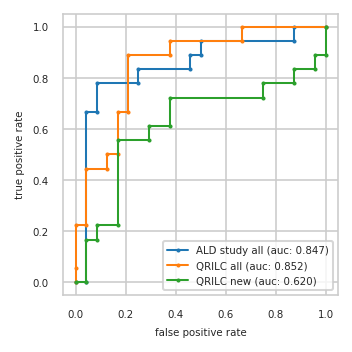

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.042 0.000     0.000 0.056     0.042 0.000
2          0.042 0.667     0.000 0.222     0.042 0.167
3          0.083 0.667     0.042 0.222     0.083 0.167
4          0.083 0.778     0.042 0.444     0.083 0.222
5          0.250 0.778     0.125 0.444     0.167 0.222
6          0.250 0.833     0.125 0.500     0.167 0.556
7          0.458 0.833     0.167 0.500     0.292 0.556
8          0.458 0.889     0.167 0.667     0.292 0.611
9          0.500 0.889     0.208 0.667     0.375 0.611
10         0.500 0.944     0.208 0.889     0.375 0.722
11         0.875 0.944     0.375 0.889     0.750 0.722
12         0.875 1.000     0.375 0.944     0.750 0.778
13         1.000 1.000     0.667 0.944     0.875 0.778
14           NaN   NaN     0.667 1.000     0.875 0.833
15           NaN   NaN     1.000 1.000     0.958 0.833
16           NaN   NaN       NaN   NaN     0.958 0.889
17           NaN   NaN       NaN   NaN     1.000 0.889
18           NaN   NaN       NaN   NaN     1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,P31321
1,Q9NX62,B1AN99;P35030;P35030-2;P35030-3;P35030-4;P35030-5,None
2,G3XAI2;P07942,P00488,None
3,B1AHL2;P23142-4,P10636-2;P10636-6,None
4,P61981,A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;...,None
5,P04075,P61981,None
6,P14174,P04075,None
7,Q9Y2T3;Q9Y2T3-3,P14174,None
8,Q99983,Q2UY09,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


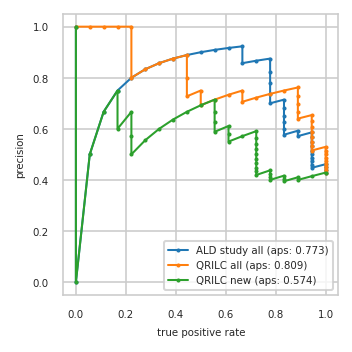

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.415 0.944
2          0.450 1.000     0.450 1.000     0.400 0.889
3          0.462 1.000     0.462 1.000     0.410 0.889
4          0.447 0.944     0.474 1.000     0.395 0.833
5          0.459 0.944     0.486 1.000     0.405 0.833
6          0.472 0.944     0.500 1.000     0.417 0.833
7          0.486 0.944     0.514 1.000     0.400 0.778
8          0.500 0.944     0.529 1.000     0.412 0.778
9          0.515 0.944     0.515 0.944     0.424 0.778
10         0.531 0.944     0.531 0.944     0.438 0.778
11         0.548 0.944     0.548 0.944     0.419 0.722
12         0.567 0.944     0.567 0.944     0.433 0.722
13         0.586 0.944     0.586 0.944     0.448 0.722
14         0.571 0.889     0.607 0.944     0.464 0.722
15         0.593 0.889     0.630 0.944     0.481 0.722
16         0.577 0.833     0.654 0.944     0.500 0.722
17         0.600 0.833     0.640 0.889     0.520 0.722
18         0.625 0.833     0.667 0.889     0.542 0.722
19         0.652 0.833     0.696 0.889     0.565 0.722
20         0.682 0.833     0.727 0.889     0.591 0.722
21         0.714 0.833     0.762 0.889     0.571 0.667
22         0.700 0.778     0.750 0.833     0.550 0.611
23         0.737 0.778     0.737 0.778     0.579 0.611
24         0.778 0.778     0.722 0.722     0.611 0.611
25         0.824 0.778     0.706 0.667     0.588 0.556
26         0.875 0.778     0.750 0.667     0.625 0.556
27         0.867 0.722     0.733 0.611     0.667 0.556
28         0.857 0.667     0.714 0.556     0.714 0.556
29         0.923 0.667     0.692 0.500     0.692 0.500
30         0.917 0.611     0.750 0.500     0.667 0.444
31         0.909 0.556     0.727 0.444     0.636 0.389
32         0.900 0.500     0.800 0.444     0.600 0.333
33         0.889 0.444     0.889 0.444     0.556 0.278
34         0.875 0.389     0.875 0.389     0.500 0.222
35         0.857 0.333     0.857 0.333     0.571 0.222
36         0.833 0.278     0.833 0.278     0.667 0.222
37         0.800 0.222     0.800 0.222     0.600 0.167
38         0.750 0.167     1.000 0.222     0.750 0.167
39         0.667 0.111     1.000 0.167     0.667 0.111
40         0.500 0.056     1.000 0.111     0.500 0.056
41         0.000 0.000     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


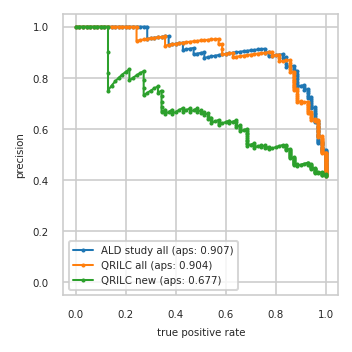

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


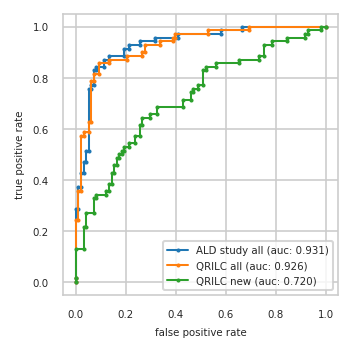

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}